In [1]:
# Pathを追加するためのスクリプト
import sys
sys.path.append("..")

import config
if str(config.SCRIPTS_DIR) not in sys.path:
    sys.path.append(str(config.SCRIPTS_DIR))

import importlib

In [23]:
# pip 系のモジュール
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas library for data manipulation and analysis
import optuna
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
# 自作のモジュール
import model_optimizer
importlib.reload(model_optimizer)

<module 'model_optimizer' from 'C:\\Users\\kazuki\\Documents\\GF_contest\\scripts\\model_optimizer.py'>

In [38]:
df1 = pd.read_csv(config.RAW_DATA_DIR/'Mot_A_rel_2.csv')
df2 = pd.read_csv(config.RAW_DATA_DIR/'Mot_B_rel_1.csv')

# df1が既に定義されていると仮定
X = df1[['d_alpha_deg', 'hc_mm', 'r', 'w_t', 'l_t', 'w_o_mm', 'dxIB', 'gamma']]
y = df1[['T', 'TR', 'm_Cu', 'm_mag', 'cos_phi', 'VM', 'Temp']]

scaler = StandardScaler()
X = scaler.fit_transform(X)
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y['TR'], test_size=0.2, random_state=42)

array([[<Axes: title={'center': 'd_alpha'}>,
        <Axes: title={'center': 'h_c'}>, <Axes: title={'center': 'r'}>,
        <Axes: title={'center': 'w_t'}>],
       [<Axes: title={'center': 'l_t'}>, <Axes: title={'center': 'w_o'}>,
        <Axes: title={'center': 'dxIB'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'd_alpha_deg'}>,
        <Axes: title={'center': 'hc_mm'}>,
        <Axes: title={'center': 'w_o_mm'}>,
        <Axes: title={'center': 'T'}>],
       [<Axes: title={'center': 'TR'}>, <Axes: title={'center': 'm_Cu'}>,
        <Axes: title={'center': 'm_mag'}>,
        <Axes: title={'center': 'cos_phi'}>],
       [<Axes: title={'center': 'VM'}>, <Axes: title={'center': 'Temp'}>,
        <Axes: >, <Axes: >]], dtype=object)

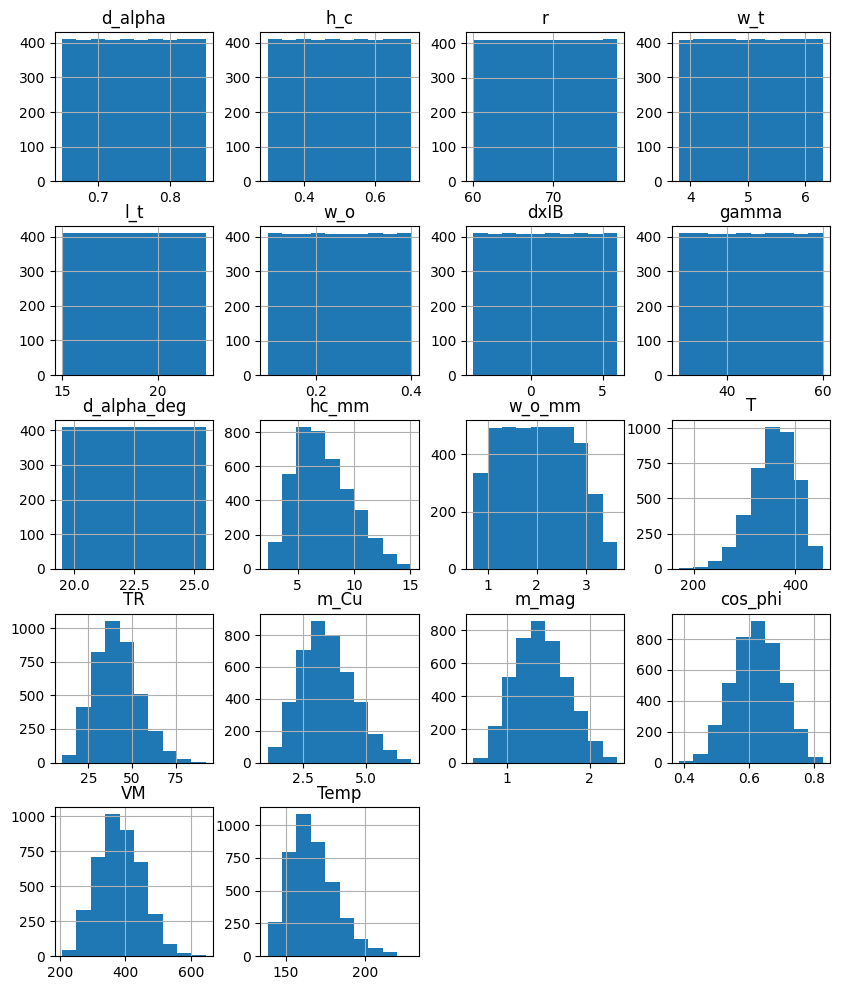

In [41]:
df1.hist(figsize=(10,12
                  ))

array([[<Axes: title={'center': 'T'}>, <Axes: title={'center': 'TR'}>,
        <Axes: title={'center': 'm_Cu'}>],
       [<Axes: title={'center': 'm_mag'}>,
        <Axes: title={'center': 'cos_phi'}>,
        <Axes: title={'center': 'VM'}>],
       [<Axes: title={'center': 'Temp'}>, <Axes: >, <Axes: >]],
      dtype=object)

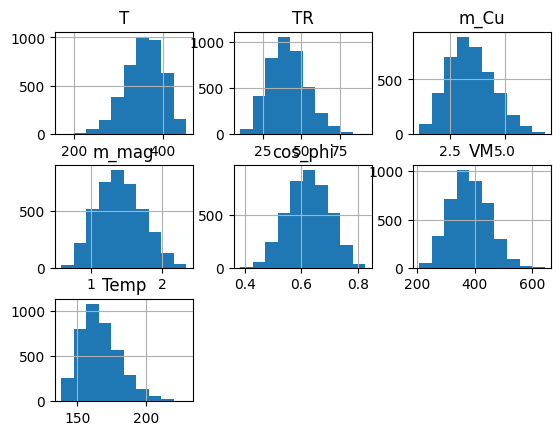

In [36]:
y.hist()

Best R2: -0.00036147483748660836
Best R2: 0.734642277546285
Best R2: 0.734642277546285
Best R2: 0.734642277546285
Best R2: 0.7687622624062599
Best R2: 0.7687622624062599
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8010380598410833
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491028738162
Best R2: 0.8036491

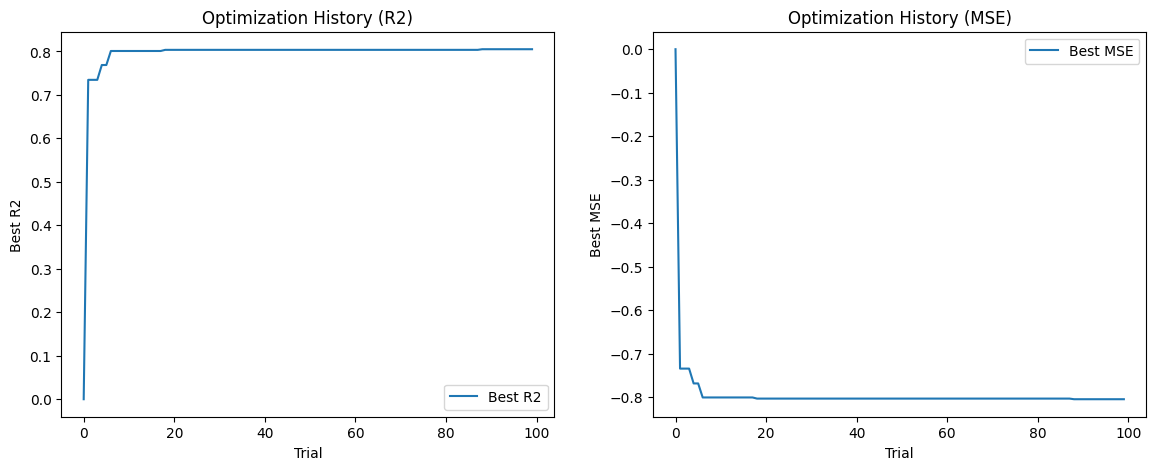

In [26]:
# 最適なハイパーパラメータを使用してモデルを学習
best_xgb = model_optimizer.optimize_xgb(X_train, y_train)
# best_svr = model_optimizer.optimize_svr(X_train, y_train)
# best_gp = model_optimizer.optimize_gpr(X_train, y_train)


In [27]:
best_xgb.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.08961743212074956,
             eval_metric=None, feature_types=None, gamma=1.2767910432254853e-05,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)>

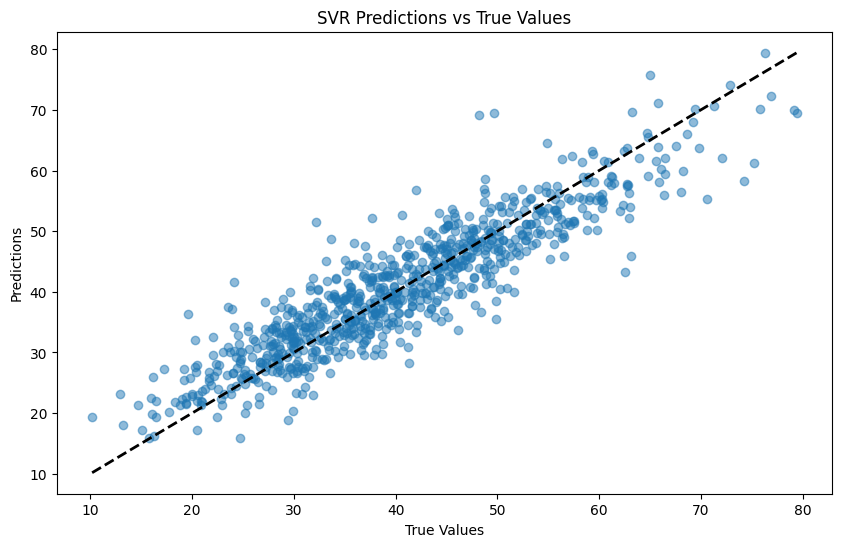

In [28]:
best_model = best_xgb
Y_test = y_test
# テストデータに対する予測
y_pred = best_model.predict(X_test)

# プロット
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('SVR Predictions vs True Values')
plt.show()

In [29]:
# 予測値と真値
y_true = Y_test
y_pred = best_model.predict(X_test)

# R²決定係数
r2 = r2_score(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

print(f'R²: {r2}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

R²: 0.8232526610250144
RMSE: 5.1548379788505665
MAE: 4.0109672095035


In [30]:
# df1が既に定義されていると仮定
X = df2[['d_alpha', 'h_c', 'r', 'w_t', 'l_t', 'w_o', 'dxIB', 'gamma']]
y = df2[['T', 'TR', 'm_Cu', 'm_mag', 'cos_phi', 'VM', 'Temp']]
y = y['TR']

R²: -9.635300434410677
RMSE: 41.390006923075596
MAE: 39.15922631116146


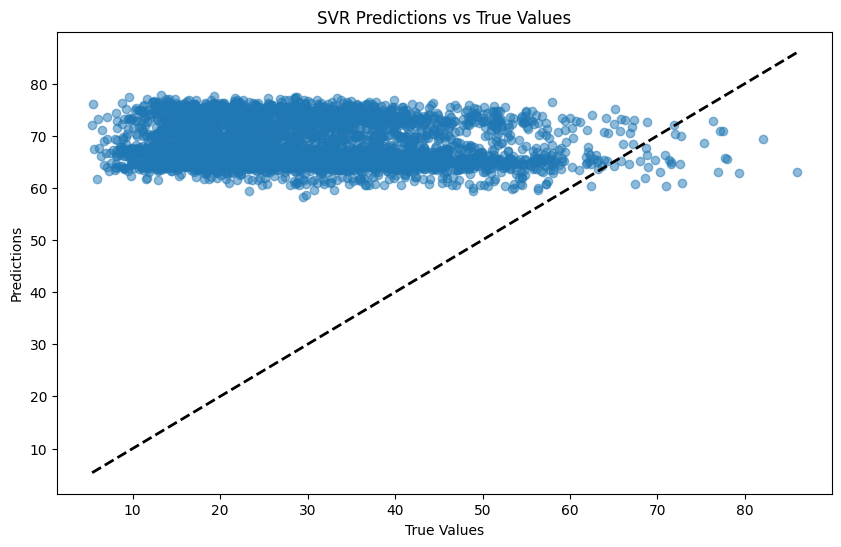

In [31]:
# 予測値と真値
y_true = y
y_pred = best_model.predict(X)

# R²決定係数
r2 = r2_score(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

print(f'R²: {r2}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# プロット
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('SVR Predictions vs True Values')
plt.show()